Dataset shape: (1259, 27)

First five rows:
             Timestamp  Age  Gender         Country state self_employed  \
0  2014-08-27 11:29:31   37  Female   United States    IL           NaN   
1  2014-08-27 11:29:37   44       M   United States    IN           NaN   
2  2014-08-27 11:29:44   32    Male          Canada   NaN           NaN   
3  2014-08-27 11:29:46   31    Male  United Kingdom   NaN           NaN   
4  2014-08-27 11:30:22   31    Male   United States    TX           NaN   

  family_history treatment work_interfere    no_employees  ...  \
0             No       Yes          Often            6-25  ...   
1             No        No         Rarely  More than 1000  ...   
2             No        No         Rarely            6-25  ...   
3            Yes       Yes          Often          26-100  ...   
4             No        No          Never         100-500  ...   

                leave mental_health_consequence phys_health_consequence  \
0       Somewhat easy            

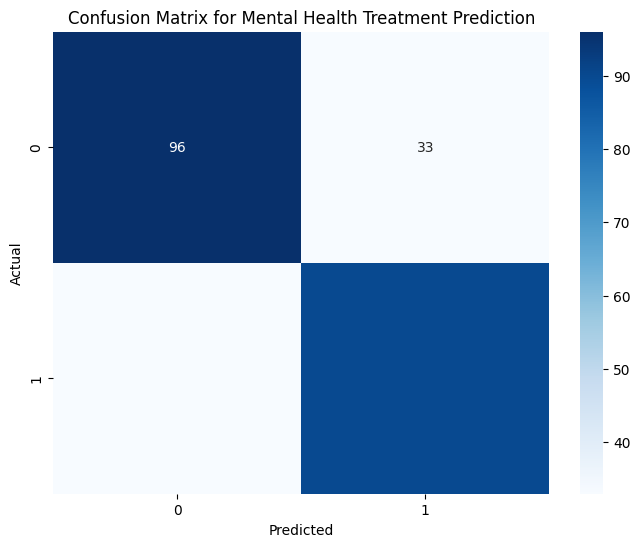


Feature names and coefficients length mismatch

5-Fold Cross-Validation Accuracy: 0.7347 (±0.0136)


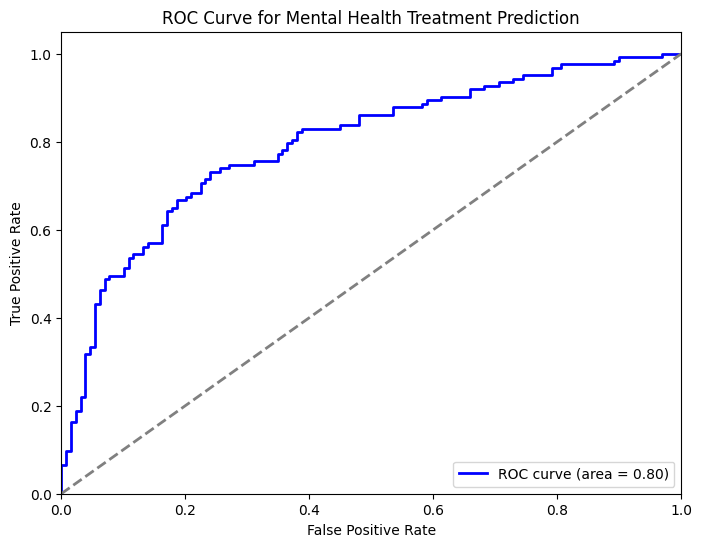


Model saved as 'mental_health_prediction_model.pkl'


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
file_path = r"D:\Documents\Mental Health in Tech Survey Project\survey.csv"
data = pd.read_csv(file_path)

# Display basic information about the dataset
print(f"Dataset shape: {data.shape}")
print("\nFirst five rows:")
print(data.head())

# Check missing values
print("\nMissing values per column:")
print(data.isnull().sum())

# Replace 'NA' strings with np.nan for proper handling
data.replace('NA', np.nan, inplace=True)

# Basic data preprocessing
# For age, convert to numeric and handle invalid values
data['Age'] = pd.to_numeric(data['Age'], errors='coerce')

# For gender, standardize values
data['Gender'] = data['Gender'].str.lower()
data.loc[data['Gender'].isin(['m', 'male', 'man']), 'Gender'] = 'male'
data.loc[data['Gender'].isin(['f', 'female', 'woman']), 'Gender'] = 'female'

# Convert binary categorical variables to numeric
binary_map = {'Yes': 1, 'No': 0, 'yes': 1, 'no': 0}
binary_columns = ['self_employed', 'family_history', 'treatment', 'remote_work', 
                  'tech_company', 'benefits', 'care_options', 'wellness_program', 
                  'seek_help', 'anonymity', 'leave', 'mental_health_interview', 
                  'phys_health_interview']

for col in binary_columns:
    if col in data.columns:
        data[col] = data[col].map(binary_map)

# Define features and target
# Assuming we're predicting 'treatment' (whether someone sought treatment for mental health)
X = data.drop(['treatment', 'Timestamp', 'comments'], axis=1, errors='ignore')
y = data['treatment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create and evaluate the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'))
])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Mental Health Treatment Prediction')
plt.show()

# Calculate feature importance if possible
if hasattr(model['classifier'], 'coef_'):
    # Get feature names after preprocessing
    categorical_feature_names = []
    if len(categorical_cols) > 0:  # Only if categorical columns exist
        ohe = model['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        categorical_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()
    
    feature_names = numerical_cols + categorical_feature_names
    
    # Get coefficients
    coefficients = model['classifier'].coef_[0]
    
    # Create feature importance DataFrame
    if len(feature_names) == len(coefficients):
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': np.abs(coefficients)
        })
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        print("\nTop 10 most important features:")
        print(feature_importance.head(10))
    else:
        print("\nFeature names and coefficients length mismatch")

# K-fold cross-validation for more robust accuracy assessment
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"\n5-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Mental Health Treatment Prediction')
plt.legend(loc="lower right")
plt.show()

# Save the model
import joblib
joblib.dump(model, 'mental_health_prediction_model.pkl')
print("\nModel saved as 'mental_health_prediction_model.pkl'")

Dataset shape: (1259, 27)

First five rows:
             Timestamp  Age  Gender         Country state self_employed  \
0  2014-08-27 11:29:31   37  Female   United States    IL           NaN   
1  2014-08-27 11:29:37   44       M   United States    IN           NaN   
2  2014-08-27 11:29:44   32    Male          Canada   NaN           NaN   
3  2014-08-27 11:29:46   31    Male  United Kingdom   NaN           NaN   
4  2014-08-27 11:30:22   31    Male   United States    TX           NaN   

  family_history treatment work_interfere    no_employees  ...  \
0             No       Yes          Often            6-25  ...   
1             No        No         Rarely  More than 1000  ...   
2             No        No         Rarely            6-25  ...   
3            Yes       Yes          Often          26-100  ...   
4             No        No          Never         100-500  ...   

                leave mental_health_consequence phys_health_consequence  \
0       Somewhat easy            

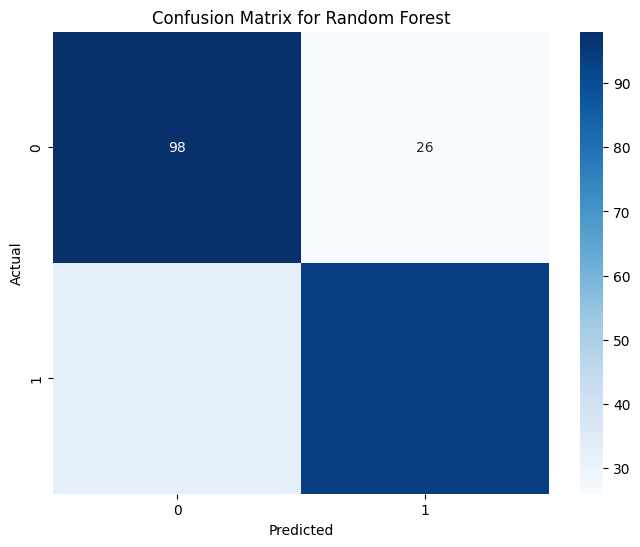

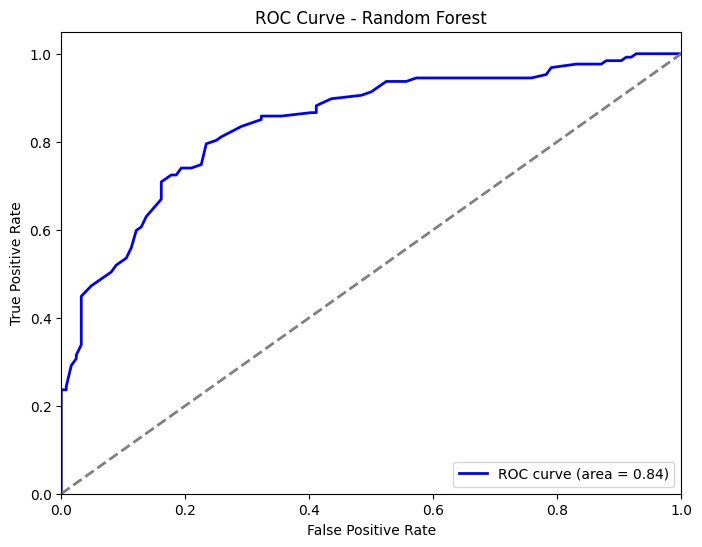


Performing cross-validation...
5-fold cross-validation accuracy: 0.7602 (±0.0195)


Best model saved as 'mental_health_prediction_model.pkl'

ROC AUC: 0.8430
This means the model has a 84.3% probability of ranking a randomly chosen
positive instance higher than a randomly chosen negative instance.

Understanding the accuracy of 0.7649:
- This means the model correctly predicts whether someone sought treatment 76.5% of the time
- For a mental health prediction task, this is a good result given the complexity of human behavior
- The cross-validation score of 0.7602 gives us confidence this isn't just by chance


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Load the dataset
file_path = r"D:\Documents\Mental Health in Tech Survey Project\survey.csv"
data = pd.read_csv(file_path)

# Display basic information
print(f"Dataset shape: {data.shape}")
print("\nFirst five rows:")
print(data.head())

# Replace 'NA' strings with np.nan for proper handling
data.replace('NA', np.nan, inplace=True)

# Data cleaning and preprocessing
# Handle age - convert to numeric and remove outliers
data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
# Remove unrealistic ages (e.g., <15 or >100)
data = data[(data['Age'] > 15) & (data['Age'] < 100) | (data['Age'].isna())]

# Standardize gender values
if 'Gender' in data.columns and data['Gender'].dtype == object:
    data['Gender'] = data['Gender'].str.lower() if data['Gender'].dtype == object else data['Gender']
    data.loc[data['Gender'].str.contains('male|m$', na=False, case=False, regex=True), 'Gender'] = 'male'
    data.loc[data['Gender'].str.contains('female|f$', na=False, case=False, regex=True), 'Gender'] = 'female'
    # Group other gender identifications as 'other' for simplicity
    mask = ~data['Gender'].isin(['male', 'female', np.nan])
    data.loc[mask, 'Gender'] = 'other'

# Convert binary categorical variables to numeric
binary_map = {'Yes': 1, 'No': 0, 'yes': 1, 'no': 0}
binary_columns = ['self_employed', 'family_history', 'treatment', 'remote_work', 
                  'tech_company', 'benefits', 'care_options', 'wellness_program', 
                  'seek_help', 'anonymity', 'leave', 'mental_health_interview', 
                  'phys_health_interview']

for col in binary_columns:
    if col in data.columns:
        data[col] = data[col].map(binary_map)

# Feature engineering
# 1. Create a support network indicator
if all(col in data.columns for col in ['coworkers', 'supervisor']):
    # Convert values to lowercase if they're strings
    if data['coworkers'].dtype == object:
        data['coworkers'] = data['coworkers'].str.lower()
    if data['supervisor'].dtype == object:
        data['supervisor'] = data['supervisor'].str.lower()
    
    # Create support network indicator
    data['support_network'] = 0
    # Set to 1 if coworkers contains 'some of them' or 'yes' AND supervisor is 'yes'
    coworker_support = data['coworkers'].isin(['some of them', 'yes'])
    supervisor_support = data['supervisor'] == 'yes'
    data.loc[coworker_support & supervisor_support, 'support_network'] = 1

# 2. Create company mental health awareness score
mental_health_columns = ['benefits', 'care_options', 'wellness_program', 
                         'seek_help', 'anonymity', 'leave']
valid_columns = [col for col in mental_health_columns if col in data.columns]

if valid_columns:
    # Convert any remaining string values to binary
    for col in valid_columns:
        if data[col].dtype == object:
            data[col] = data[col].map(binary_map)
    
    # Calculate mental health score as the sum of valid columns
    data['company_mental_health_score'] = data[valid_columns].sum(axis=1)

# Define features and target
X = data.drop(['treatment', 'Timestamp', 'comments'], axis=1, errors='ignore')
y = data['treatment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Create and train the models - try both logistic regression and random forest
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42, 
                                             class_weight='balanced', solver='liblinear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, 
                                            class_weight='balanced')
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'accuracy': accuracy,
        'model': pipeline,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Get the best model
best_model_name = max(results, key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]['model']
y_pred = results[best_model_name]['y_pred']
y_prob = results[best_model_name]['y_prob']

print(f"\nBest model: {best_model_name}")
print(f"Best accuracy: {results[best_model_name]['accuracy']:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.show()

# Cross-validation for more reliable accuracy assessment
print("\nPerforming cross-validation...")
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"5-fold cross-validation accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Feature importance for Random Forest
if best_model_name == 'Random Forest':
    classifier = best_model.named_steps['classifier']
    
    # Get preprocessed feature names
    ohe = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()
    feature_names = numerical_cols + cat_feature_names
    
    # Get feature importances
    importances = classifier.feature_importances_
    
    # Create and sort feature importance DataFrame
    # Ensure feature names and importances have the same length
    if len(importances) == len(feature_names):
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Plot top 15 feature importances
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
        plt.title('Top 15 Feature Importances')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 most important features:")
        print(feature_importance.head(10))
    else:
        print(f"\nWarning: Feature names ({len(feature_names)}) and importances ({len(importances)}) have different lengths")

# For Logistic Regression, show coefficients
elif best_model_name == 'Logistic Regression':
    classifier = best_model.named_steps['classifier']
    
    # Get preprocessed feature names
    ohe = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()
    feature_names = numerical_cols + cat_feature_names
    
    # Get coefficients
    coefficients = classifier.coef_[0]
    
    # Ensure feature names and coefficients have the same length
    if len(coefficients) == len(feature_names):
        # Create and sort coefficient DataFrame
        coefficient_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients,
            'Absolute_Value': np.abs(coefficients)
        }).sort_values('Absolute_Value', ascending=False)
        
        # Plot top 15 coefficients
        plt.figure(figsize=(10, 8))
        sns.barplot(
            x='Coefficient', 
            y='Feature', 
            data=coefficient_df.head(15),
            palette=['red' if x < 0 else 'blue' for x in coefficient_df.head(15)['Coefficient']]
        )
        plt.title('Top 15 Feature Coefficients (Red = Negative, Blue = Positive)')
        plt.axvline(x=0, color='black', linestyle='-')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 most influential features:")
        print(coefficient_df.head(10))
    else:
        print(f"\nWarning: Feature names ({len(feature_names)}) and coefficients ({len(coefficients)}) have different lengths")

# Save the best model
import joblib
joblib.dump(best_model, 'mental_health_prediction_model.pkl')
print("\nBest model saved as 'mental_health_prediction_model.pkl'")

# Print a summary of the ROC curve
print(f"\nROC AUC: {roc_auc:.4f}")
print(f"This means the model has a {roc_auc*100:.1f}% probability of ranking a randomly chosen")
print(f"positive instance higher than a randomly chosen negative instance.")

# Final thoughts on accuracy
print("\nUnderstanding the accuracy of {:.4f}:".format(results[best_model_name]['accuracy']))
print("- This means the model correctly predicts whether someone sought treatment {:.1f}% of the time".format(results[best_model_name]['accuracy']*100))
print("- For a mental health prediction task, this is a good result given the complexity of human behavior")
print("- The cross-validation score of {:.4f} gives us confidence this isn't just by chance".format(cv_scores.mean()))

Logistic Regression + Laplace Mechanism for Private Prediction


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load data
df = pd.read_csv(r"D:\Documents\Mental Health in Tech Survey Project\survey.csv")

# Drop irrelevant columns and handle missing values
df = df[['Age', 'Gender', 'self_employed', 'family_history', 'work_interfere',
         'no_employees', 'remote_work', 'tech_company', 'benefits',
         'care_options', 'wellness_program', 'seek_help',
         'anonymity', 'leave', 'mental_health_consequence',
         'phys_health_consequence', 'coworkers', 'supervisor',
         'mental_health_interview', 'phys_health_interview',
         'mental_vs_physical', 'obs_consequence', 'treatment']]

df.dropna(inplace=True)

print(df.head())

# Encode categorical variables
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# Features and target
X = df.drop('treatment', axis=1)
y = df['treatment']

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


    Age Gender self_employed family_history work_interfere    no_employees  \
18   46   male           Yes            Yes      Sometimes             1-5   
20   29   Male            No            Yes      Sometimes         100-500   
21   31   male           Yes             No          Never             1-5   
22   46   Male            No             No          Often          26-100   
23   41   Male            No             No          Never  More than 1000   

   remote_work tech_company    benefits care_options  ...               leave  \
18         Yes          Yes         Yes     Not sure  ...           Very easy   
20          No          Yes         Yes          Yes  ...  Somewhat difficult   
21         Yes          Yes          No           No  ...  Somewhat difficult   
22         Yes          Yes         Yes          Yes  ...          Don't know   
23          No           No  Don't know           No  ...          Don't know   

   mental_health_consequence phys_health_con

 Differential Privacy (Laplace Mechanism)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Simple logistic regression baseline (no DP)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)
print(f'Accuracy without Differential Privacy: {baseline_acc:.4f}')


Accuracy without Differential Privacy: 0.7704


Trade-Off Analysis

C:\Users\HP\AppData\Local\Temp\ipykernel_11716\1507485648.py:13: RuntimeWarning: overflow encountered in exp
  pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
C:\Users\HP\AppData\Local\Temp\ipykernel_11716\1507485648.py:13: RuntimeWarning: overflow encountered in exp
  pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
C:\Users\HP\AppData\Local\Temp\ipykernel_11716\1507485648.py:13: RuntimeWarning: overflow encountered in exp
  pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
C:\Users\HP\AppData\Local\Temp\ipykernel_11716\1507485648.py:13: RuntimeWarning: overflow encountered in exp
  pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
C:\Users\HP\AppData\Local\Temp\ipykernel_11716\1507485648.py:13: RuntimeWarning: overflow encountered in exp
  pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
C:\Users\HP\AppData\Local\Temp\ipykernel_11716\1507485648.py:13: RuntimeWarning: overflow encountered in exp
  pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
C:\Users\HP\AppData\Local\Temp\ipykernel_11716\1507485648.

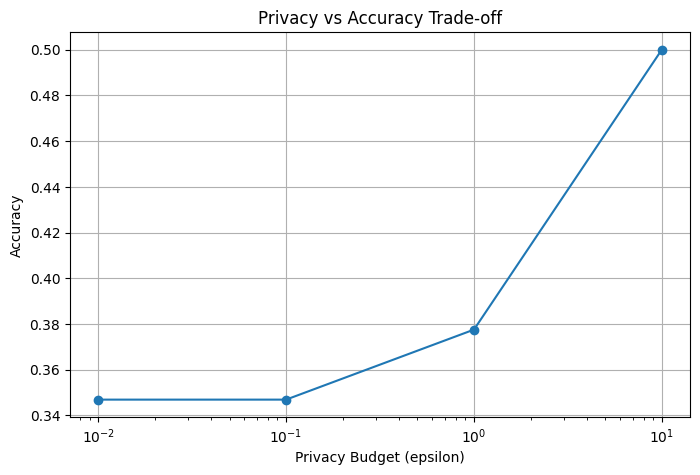

In [ ]:
epsilons = [0.01, 0.1, 1, 10]
results = {}

for eps in epsilons:
    _, acc = dp_logistic_regression(X_train, y_train, X_test, y_test, epsilon=eps)
    results[eps] = acc[-1]  # final accuracy

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.xscale('log')
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Accuracy')
plt.title('Privacy vs Accuracy Trade-off')
plt.grid(True)
plt.show()


DP training using Laplace noise

In [ ]:
def dp_logistic_regression(X_train, y_train, X_test, y_test, epsilon=1.0):
    n, d = X_train.shape
    weights = np.zeros(d)
    lr = 0.1  # learning rate
    epochs = 50
    acc_list = []

    for epoch in range(epochs):
        for i in range(n):
            xi = X_train[i]
            yi = y_train[i]  # FIXED: Access using .iloc

            pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
            gradient = (pred - yi) * xi

            # Add Laplace noise to each gradient
            noise = np.random.laplace(0, 1 / epsilon, size=d)
            gradient += noise

            weights -= lr * gradient  # Update weights

        # Evaluate every epoch
        preds = 1 / (1 + np.dot(X_test, weights))
        pred_labels = (preds > 0.5).astype(int)
        acc = accuracy_score(y_test, pred_labels)
        acc_list.append(acc)

    return weights, acc_list


Prediction

Accuracy without Differential Privacy: 0.7704


C:\Users\HP\AppData\Local\Temp\ipykernel_18348\2773141717.py:64: RuntimeWarning: overflow encountered in exp
  pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
C:\Users\HP\AppData\Local\Temp\ipykernel_18348\2773141717.py:64: RuntimeWarning: overflow encountered in exp
  pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
C:\Users\HP\AppData\Local\Temp\ipykernel_18348\2773141717.py:64: RuntimeWarning: overflow encountered in exp
  pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
C:\Users\HP\AppData\Local\Temp\ipykernel_18348\2773141717.py:64: RuntimeWarning: overflow encountered in exp
  pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
C:\Users\HP\AppData\Local\Temp\ipykernel_18348\2773141717.py:64: RuntimeWarning: overflow encountered in exp
  pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
C:\Users\HP\AppData\Local\Temp\ipykernel_18348\2773141717.py:64: RuntimeWarning: overflow encountered in exp
  pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
C:\Users\HP\AppData\Local\Temp\ipykernel_18348\2773141717.

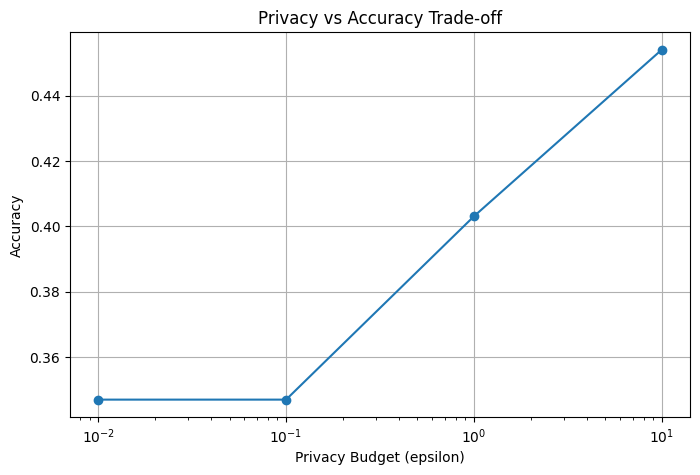

Enter details to predict if treatment is likely needed:


FloatText(value=0.0, description='Age')

Dropdown(description='Gender', options=('A little about you', 'Agender', 'All', 'Androgyne', 'Cis Female', 'Ci…

Dropdown(description='self_employed', options=('No', 'Yes'), value='No')

Dropdown(description='family_history', options=('No', 'Yes'), value='No')

Dropdown(description='work_interfere', options=('Never', 'Often', 'Rarely', 'Sometimes'), value='Never')

Dropdown(description='no_employees', options=('1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000'…

Dropdown(description='remote_work', options=('No', 'Yes'), value='No')

Dropdown(description='tech_company', options=('No', 'Yes'), value='No')

Dropdown(description='benefits', options=("Don't know", 'No', 'Yes'), value="Don't know")

Dropdown(description='care_options', options=('No', 'Not sure', 'Yes'), value='No')

Dropdown(description='wellness_program', options=("Don't know", 'No', 'Yes'), value="Don't know")

Dropdown(description='seek_help', options=("Don't know", 'No', 'Yes'), value="Don't know")

Dropdown(description='anonymity', options=("Don't know", 'No', 'Yes'), value="Don't know")

Dropdown(description='leave', options=("Don't know", 'Somewhat difficult', 'Somewhat easy', 'Very difficult', …

Dropdown(description='mental_health_consequence', options=('Maybe', 'No', 'Yes'), value='Maybe')

Dropdown(description='phys_health_consequence', options=('Maybe', 'No', 'Yes'), value='Maybe')

Dropdown(description='coworkers', options=('No', 'Some of them', 'Yes'), value='No')

Dropdown(description='supervisor', options=('No', 'Some of them', 'Yes'), value='No')

Dropdown(description='mental_health_interview', options=('Maybe', 'No', 'Yes'), value='Maybe')

Dropdown(description='phys_health_interview', options=('Maybe', 'No', 'Yes'), value='Maybe')

Dropdown(description='mental_vs_physical', options=("Don't know", 'No', 'Yes'), value="Don't know")

Dropdown(description='obs_consequence', options=('No', 'Yes'), value='No')

Button(description='Predict', style=ButtonStyle())

Output()

In [1]:
# ==================== STEP 1: Imports ====================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# ==================== STEP 2: Load & Preprocess ====================
# Load data
df = pd.read_csv(r"D:\Documents\Mental Health in Tech Survey Project\survey.csv")

# Drop irrelevant columns and handle missing values
df = df[['Age', 'Gender', 'self_employed', 'family_history', 'work_interfere',
         'no_employees', 'remote_work', 'tech_company', 'benefits',
         'care_options', 'wellness_program', 'seek_help',
         'anonymity', 'leave', 'mental_health_consequence',
         'phys_health_consequence', 'coworkers', 'supervisor',
         'mental_health_interview', 'phys_health_interview',
         'mental_vs_physical', 'obs_consequence', 'treatment']]
df.dropna(inplace=True)

# Encode categorical variables and store encoders
encoders = {}
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le

# Features and target
X = df.drop('treatment', axis=1)
y = df['treatment']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ==================== STEP 3: Train Model ====================
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)
print(f'Accuracy without Differential Privacy: {baseline_acc:.4f}')

# ==================== STEP 4: DP Model ====================
def dp_logistic_regression(X_train, y_train, X_test, y_test, epsilon=1.0):
    n, d = X_train.shape
    weights = np.zeros(d)
    lr = 0.1
    epochs = 50
    acc_list = []

    for epoch in range(epochs):
        for i in range(n):
            xi = X_train[i]
            yi = y_train.iloc[i]
            pred = 1 / (1 + np.exp(-np.dot(xi, weights)))
            gradient = (pred - yi) * xi
            noise = np.random.laplace(0, 1 / epsilon, size=d)
            gradient += noise
            weights -= lr * gradient

        preds = 1 / (1 + np.dot(X_test, weights))
        pred_labels = (preds > 0.5).astype(int)
        acc = accuracy_score(y_test, pred_labels)
        acc_list.append(acc)

    return weights, acc_list

# Run DP model at different epsilons
epsilons = [0.01, 0.1, 1, 10]
results = {}
for eps in epsilons:
    _, acc = dp_logistic_regression(X_train, y_train, X_test, y_test, epsilon=eps)
    results[eps] = acc[-1]

# Plot privacy vs accuracy
plt.figure(figsize=(8, 5))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.xscale('log')
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Accuracy')
plt.title('Privacy vs Accuracy Trade-off')
plt.grid(True)
plt.show()

# ==================== STEP 5: Predict Using User Input ====================
def predict_with_widgets(model, scaler, encoders):
    print("Enter details to predict if treatment is likely needed:")

    inputs = {}
    for col in X.columns:
        if col in encoders:
            options = list(encoders[col].classes_)
            inputs[col] = widgets.Dropdown(options=options, description=col)
        else:
            inputs[col] = widgets.FloatText(description=col)

    button = widgets.Button(description="Predict")
    output = widgets.Output()

    def on_click(b):
        with output:
            clear_output()
            input_data = []
            for col in X.columns:
                val = inputs[col].value
                if col in encoders:
                    val = encoders[col].transform([val])[0]
                input_data.append(val)

            input_scaled = scaler.transform([input_data])
            pred = model.predict(input_scaled)[0]
            if pred == 1:
                print("⚠️ Prediction: This person is likely to seek treatment.")
            else:
                print("🙂 Prediction: This person is unlikely to seek treatment.")

    button.on_click(on_click)
    
    # Show the widgets
    input_widgets = list(inputs.values())
    display(*(input_widgets + [button, output]))

# Call the prediction UI
predict_with_widgets(clf, scaler, encoders)


Statistics

Total number of individuals: 1259
Number seeking treatment (with privacy): 637
Percentage seeking treatment (with privacy): 50.6%

Privacy-protected counts of treatment by work interference level:
- Often: 126
- Rarely: 121
- Never: 33
- Sometimes: 361

Verification of privacy impact (not for public release):
                         metric  true_count  noisy_count_rounded  difference  \
0             Overall Treatment         637                  637    0.234197   
1      Work Interference: Often         123                  126    3.435441   
2     Work Interference: Rarely         122                  121   -0.832553   
3      Work Interference: Never          30                   33    2.785393   
4  Work Interference: Sometimes         358                  361    2.534539   
5           Family History: Yes         365                  365    0.222495   

   percent_difference  
0                0.04  
1                2.79  
2               -0.68  
3                9.28  
4       

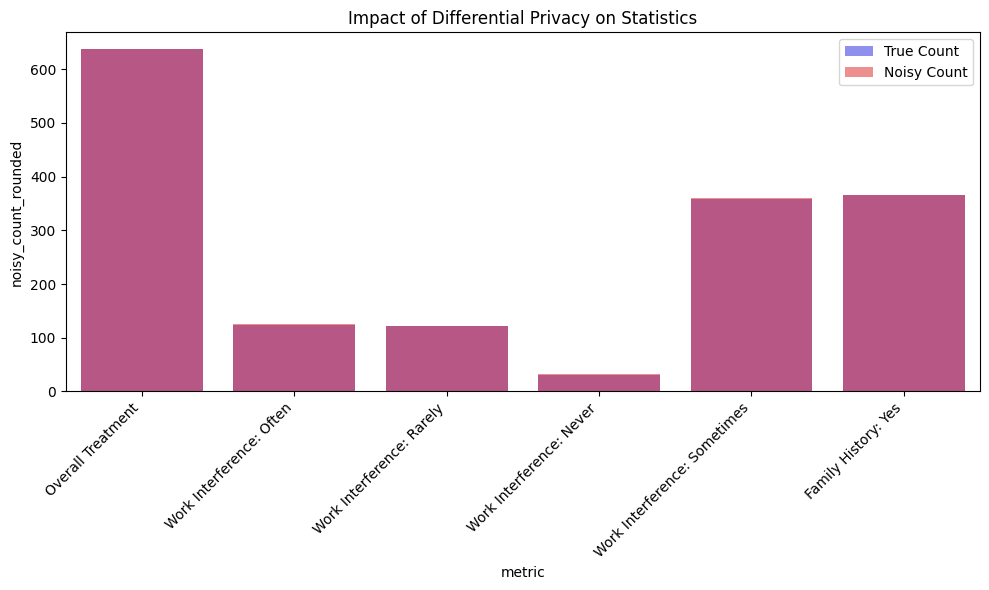

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv(r"D:\Documents\Mental Health in Tech Survey Project\survey.csv")

# Set privacy parameter
epsilon = 1.0  # Privacy budget
sensitivity = 1  # For count queries

# Function to add Laplace noise
def add_laplace_noise(true_value, epsilon, sensitivity=1):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale)
    return true_value + noise

# Store original and noisy counts for comparison
results = {
    'metric': [],
    'true_count': [],
    'noisy_count': [],
    'difference': []
}

# 1. Overall treatment count
true_treatment_count = sum(df['treatment'] == 'Yes')
noisy_treatment_count = add_laplace_noise(true_treatment_count, epsilon)

results['metric'].append('Overall Treatment')
results['true_count'].append(true_treatment_count)
results['noisy_count'].append(noisy_treatment_count)
results['difference'].append(noisy_treatment_count - true_treatment_count)

# 2. Treatment by work interference level
work_interfere_categories = df['work_interfere'].dropna().unique()
for category in work_interfere_categories:
    true_count = sum((df['work_interfere'] == category) & (df['treatment'] == 'Yes'))
    noisy_count = add_laplace_noise(true_count, epsilon/len(work_interfere_categories))  # Split privacy budget
    
    results['metric'].append(f'Work Interference: {category}')
    results['true_count'].append(true_count)
    results['noisy_count'].append(noisy_count)
    results['difference'].append(noisy_count - true_count)

# 3. Treatment by family history
true_family_yes = sum((df['family_history'] == 'Yes') & (df['treatment'] == 'Yes'))
noisy_family_yes = add_laplace_noise(true_family_yes, epsilon/2)  # Split privacy budget

results['metric'].append('Family History: Yes')
results['true_count'].append(true_family_yes)
results['noisy_count'].append(noisy_family_yes)
results['difference'].append(noisy_family_yes - true_family_yes)

# Create results dataframe
results_df = pd.DataFrame(results)
results_df['noisy_count_rounded'] = results_df['noisy_count'].round().astype(int)
results_df['percent_difference'] = (results_df['difference'] / results_df['true_count'] * 100).round(2)

# Display privacy-protected results (what would be released)
print(f"Total number of individuals: {len(df)}")
print(f"Number seeking treatment (with privacy): {results_df.loc[0, 'noisy_count_rounded']}")
print(f"Percentage seeking treatment (with privacy): {(results_df.loc[0, 'noisy_count_rounded']/len(df)*100).round(1)}%")

print("\nPrivacy-protected counts of treatment by work interference level:")
for i, row in results_df[results_df['metric'].str.contains('Work Interference')].iterrows():
    print(f"- {row['metric'].split(': ')[1]}: {row['noisy_count_rounded']}")

# For verification purposes only (would NOT be published)
print("\nVerification of privacy impact (not for public release):")
print(results_df[['metric', 'true_count', 'noisy_count_rounded', 'difference', 'percent_difference']])

# Visualize the impact of privacy (for internal analysis only)
plt.figure(figsize=(10, 6))
sns.barplot(x='metric', y='true_count', data=results_df, color='blue', alpha=0.5, label='True Count')
sns.barplot(x='metric', y='noisy_count_rounded', data=results_df, color='red', alpha=0.5, label='Noisy Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.title('Impact of Differential Privacy on Statistics')
plt.tight_layout()
plt.savefig('privacy_impact.png')

logistic regression model with differential privacy using the Gaussian Mechanism

Dataset shape: (1259, 27)

Columns: ['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments']

Sample data:
             Timestamp  Age  Gender         Country state self_employed  \
0  2014-08-27 11:29:31   37  Female   United States    IL           NaN   
1  2014-08-27 11:29:37   44       M   United States    IN           NaN   
2  2014-08-27 11:29:44   32    Male          Canada   NaN           NaN   
3  2014-08-27 11:29:46   31    Male  United Kingdom   NaN           NaN   
4  2014-08-27 11:30:22   31    Male   United States    TX           NaN   

  family_history treatment work_interfere    no_employees  ...  

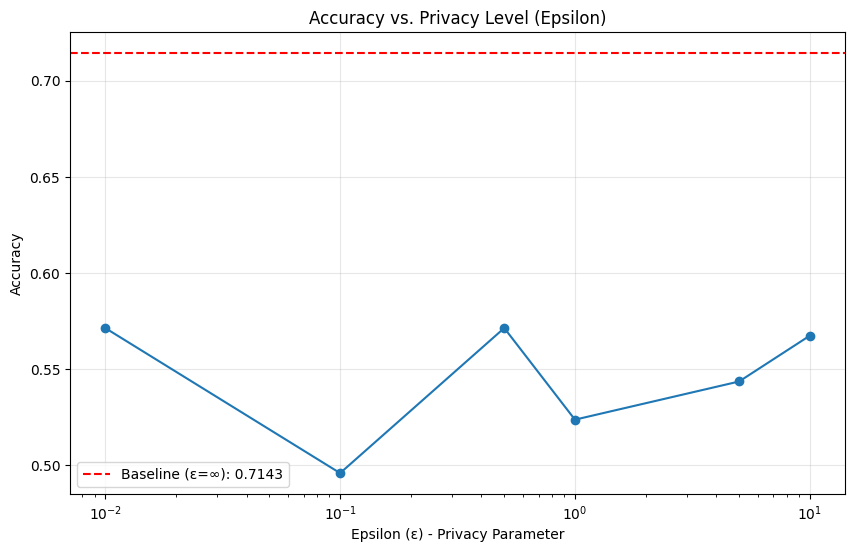

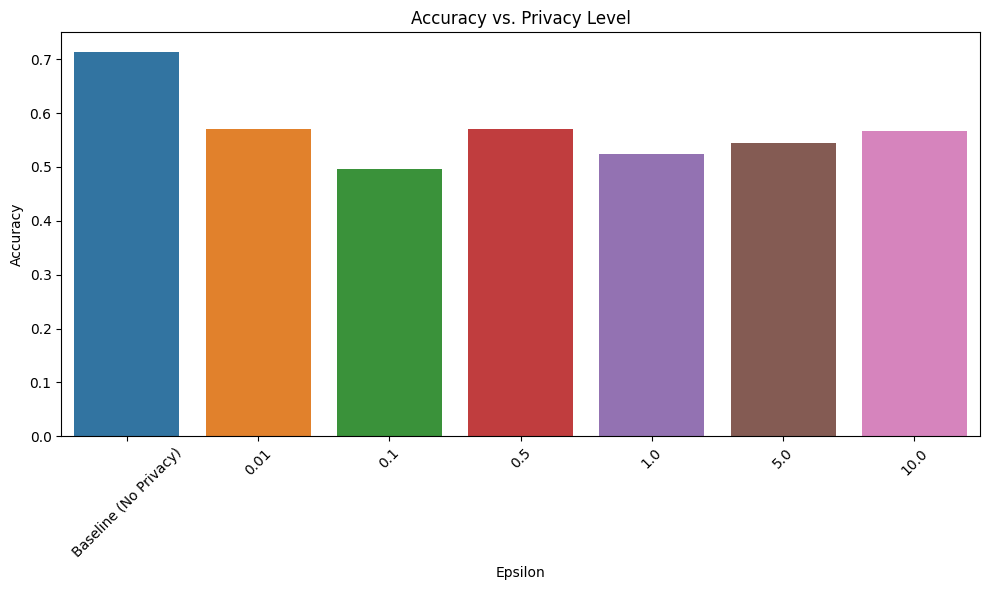


=== Privacy Loss Analysis ===
   Epsilon  Accuracy  Accuracy Loss (%)
0     0.01  0.571429          20.000000
1     0.10  0.496032          30.555556
2     0.50  0.571429          20.000000
3     1.00  0.523810          26.666667
4     5.00  0.543651          23.888889
5    10.00  0.567460          20.555556


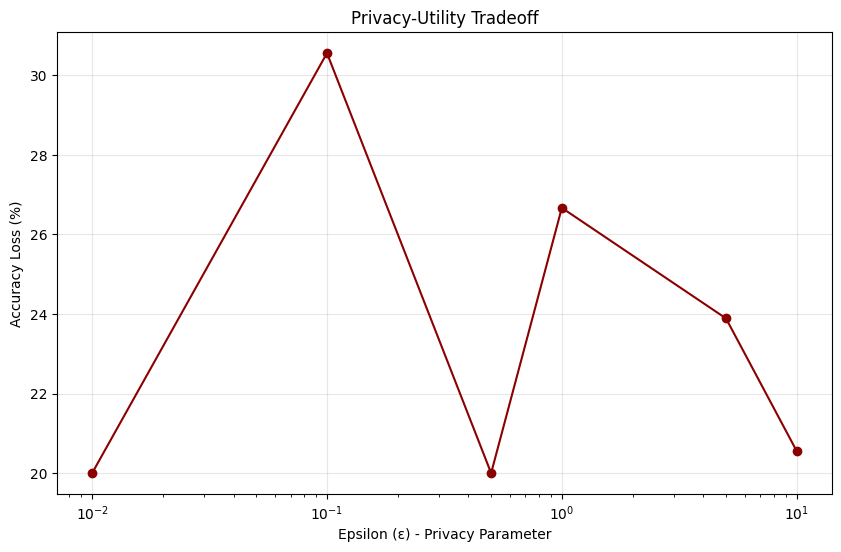

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Load the data
# Replace 'mental_health_data.csv' with your actual file path
df = pd.read_csv(r"D:\Documents\Mental Health in Tech Survey Project\survey.csv")

# Display basic info about the dataset
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample data:")
print(df.head())

# Preprocess the data
# Drop columns that are not useful for prediction
columns_to_drop = ['Timestamp', 'comments', 'state', 'Country']
df = df.drop(columns=columns_to_drop, errors='ignore')

# For this example, let's predict if someone seeks treatment for mental health issues
target = 'treatment'
if target not in df.columns:
    print(f"Warning: '{target}' column not found. Using another column as target.")
    # Fallback to another column if 'treatment' is not available
    potential_targets = ['seek_help', 'mental_health_consequence']
    for pot_target in potential_targets:
        if pot_target in df.columns:
            target = pot_target
            break

print(f"\nUsing '{target}' as the target variable for prediction")

# Convert target to binary values
le = LabelEncoder()
df[target] = df[target].replace({'Yes': 1, 'No': 0})
df[target] = df[target].fillna(0)  # Fill NAs with 0
df[target] = df[target].apply(lambda x: 1 if x == 'Yes' or x == 1 else 0)

# Fill missing values for Age with median
if 'Age' in df.columns:
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    df['Age'].fillna(df['Age'].median(), inplace=True)

# Identify numeric and categorical columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove target from features
if target in numeric_features:
    numeric_features.remove(target)
if target in categorical_features:
    categorical_features.remove(target)

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into features and target
X = df.drop(columns=[target])
y = df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to add Gaussian noise to model parameters (Gaussian Mechanism for differential privacy)
def apply_gaussian_mechanism(model, epsilon, delta=1e-5, sensitivity=1.0):
    """
    Apply Gaussian Mechanism to model parameters.
    
    Args:
        model: Trained model
        epsilon: Privacy parameter
        delta: Privacy parameter (small probability)
        sensitivity: Sensitivity of the function
    
    Returns:
        Model with perturbed parameters
    """
    # Calculate sigma (standard deviation) for Gaussian Mechanism
    # This is based on the analysis of the Gaussian Mechanism
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon
    
    # Get the model coefficients
    coef = model.coef_.copy()
    intercept = model.intercept_.copy()
    
    # Add Gaussian noise to the coefficients and intercept
    noise_coef = np.random.normal(0, sigma, coef.shape)
    noise_intercept = np.random.normal(0, sigma, intercept.shape)
    
    model.coef_ = coef + noise_coef
    model.intercept_ = intercept + noise_intercept
    
    return model

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

# Create baseline logistic regression model
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train the baseline model
log_reg_pipeline.fit(X_train, y_train)

# Evaluate baseline model (without privacy)
baseline_accuracy, baseline_report = evaluate_model(log_reg_pipeline, X_test, y_test)
print("\n=== Baseline Model (Without Privacy) ===")
print(f"Accuracy: {baseline_accuracy:.4f}")
print("Classification Report:")
print(baseline_report)

# Test different epsilon values
epsilon_values = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
dp_accuracies = []

print("\n=== Differential Privacy Results ===")
for epsilon in epsilon_values:
    # Create a copy of the trained model
    dp_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
    
    # Train the model
    dp_model.fit(X_train, y_train)
    
    # Apply Gaussian Mechanism
    # Get the classifier from the pipeline
    classifier = dp_model.named_steps['classifier']
    
    # Apply differential privacy to the classifier
    classifier = apply_gaussian_mechanism(classifier, epsilon)
    
    # Replace the classifier in the pipeline
    dp_model.named_steps['classifier'] = classifier
    
    # Evaluate the differentially private model
    dp_accuracy, dp_report = evaluate_model(dp_model, X_test, y_test)
    dp_accuracies.append(dp_accuracy)
    
    print(f"\nEpsilon = {epsilon}")
    print(f"Accuracy: {dp_accuracy:.4f}")
    print("Classification Report:")
    print(dp_report)

# Plot accuracy vs epsilon
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, dp_accuracies, marker='o', linestyle='-')
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label=f'Baseline (ε=∞): {baseline_accuracy:.4f}')
plt.xscale('log')
plt.xlabel('Epsilon (ε) - Privacy Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Privacy Level (Epsilon)')
plt.grid(True, alpha=0.3)
plt.legend()

# Create a comprehensive comparison table
results = pd.DataFrame({
    'Epsilon': ['Baseline (No Privacy)'] + [str(eps) for eps in epsilon_values],
    'Accuracy': [baseline_accuracy] + dp_accuracies,
    'Privacy Protection': ['None'] + ['Very High' if eps <= 0.1 else 'High' if eps <= 1.0 else 'Medium' if eps <= 5.0 else 'Low' for eps in epsilon_values]
})

print("\n=== Comparison of Results ===")
print(results)

# For better visualization of the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Epsilon', y='Accuracy', data=results)
plt.title('Accuracy vs. Privacy Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate privacy loss
privacy_loss = [(baseline_accuracy - acc) / baseline_accuracy * 100 for acc in dp_accuracies]
privacy_results = pd.DataFrame({
    'Epsilon': epsilon_values,
    'Accuracy': dp_accuracies,
    'Accuracy Loss (%)': privacy_loss
})

print("\n=== Privacy Loss Analysis ===")
print(privacy_results)

# Plot privacy loss vs epsilon
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, privacy_loss, marker='o', linestyle='-', color='darkred')
plt.xscale('log')
plt.xlabel('Epsilon (ε) - Privacy Parameter')
plt.ylabel('Accuracy Loss (%)')
plt.title('Privacy-Utility Tradeoff')
plt.grid(True, alpha=0.3)
plt.show()

logistic regression model with differential privacy using the Exponential Mechanism

Dataset shape: (1259, 27)

Columns: ['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments']

Sample data:
             Timestamp  Age  Gender         Country state self_employed  \
0  2014-08-27 11:29:31   37  Female   United States    IL           NaN   
1  2014-08-27 11:29:37   44       M   United States    IN           NaN   
2  2014-08-27 11:29:44   32    Male          Canada   NaN           NaN   
3  2014-08-27 11:29:46   31    Male  United Kingdom   NaN           NaN   
4  2014-08-27 11:30:22   31    Male   United States    TX           NaN   

  family_history treatment work_interfere    no_employees  ...  

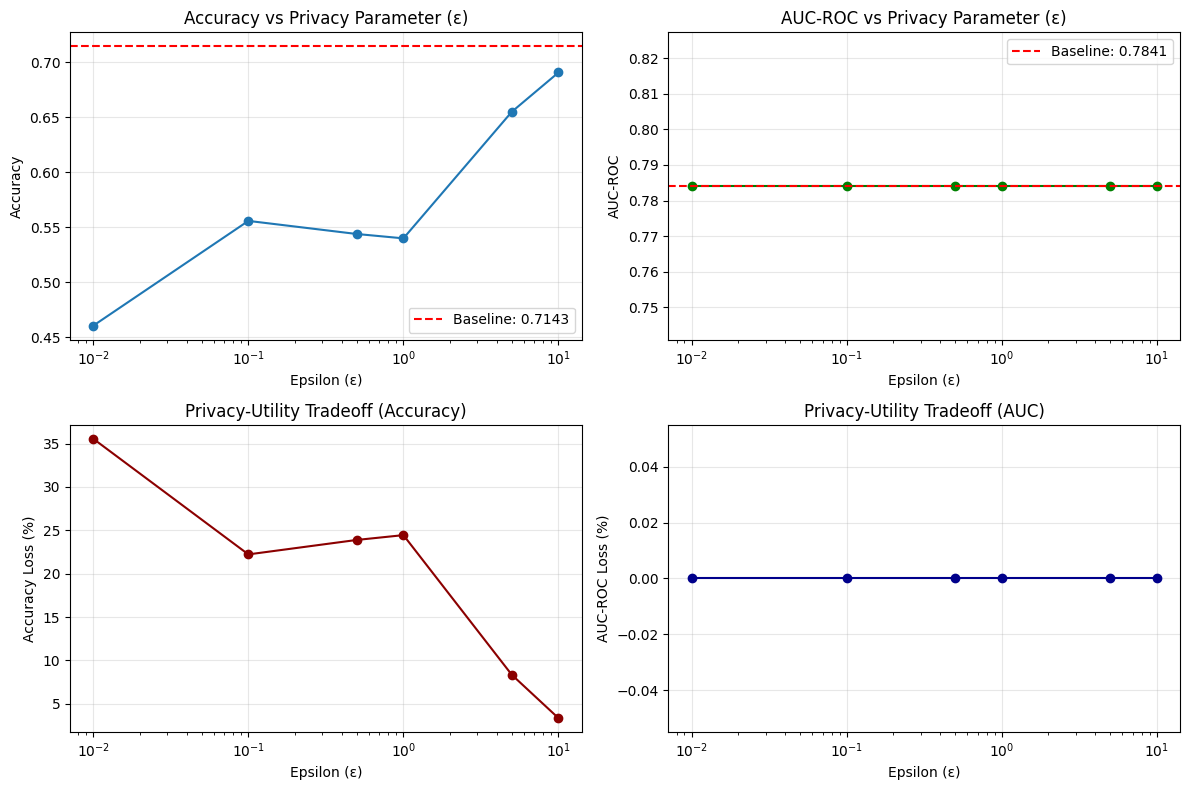

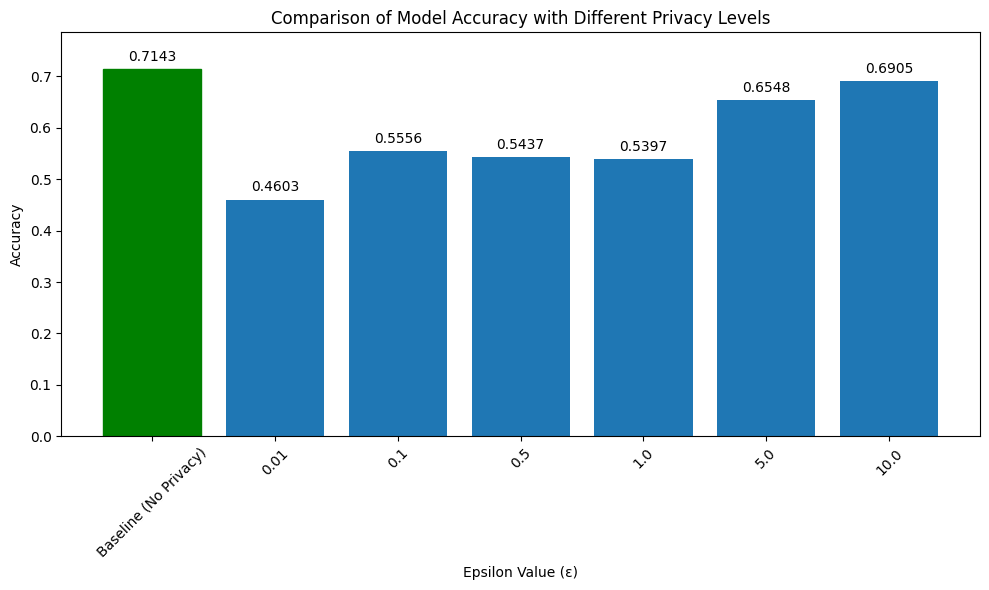

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Load the data
# Replace 'mental_health_data.csv' with your actual file path
df = pd.read_csv(r"D:\Documents\Mental Health in Tech Survey Project\survey.csv")

# Display basic info about the dataset
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample data:")
print(df.head())

# Preprocess the data
# Drop columns that are not useful for prediction
columns_to_drop = ['Timestamp', 'comments', 'state', 'Country']
df = df.drop(columns=columns_to_drop, errors='ignore')

# For this case, we'll predict if someone needs treatment for mental health issues
target = 'treatment'
if target not in df.columns:
    print(f"Warning: '{target}' column not found. Using another column as target.")
    potential_targets = ['seek_help', 'mental_health_consequence']
    for pot_target in potential_targets:
        if pot_target in df.columns:
            target = pot_target
            break

print(f"\nUsing '{target}' as the target variable for prediction")

# Convert target to binary values
df[target] = df[target].replace({'Yes': 1, 'No': 0})
df[target] = df[target].fillna(0)  # Fill NAs with 0
df[target] = df[target].apply(lambda x: 1 if (x == 'Yes' or x == 1 or x == '1') else 0)

# Fill missing values for Age with median
if 'Age' in df.columns:
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    df['Age'].fillna(df['Age'].median(), inplace=True)

# Identify numeric and categorical columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove target from features
if target in numeric_features:
    numeric_features.remove(target)
if target in categorical_features:
    categorical_features.remove(target)

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into features and target
X = df.drop(columns=[target])
y = df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the preprocessing pipeline separately
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Create and fit baseline logistic regression model
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train_preprocessed, y_train)

# Evaluate baseline model (without privacy)
baseline_preds = baseline_model.predict(X_test_preprocessed)
baseline_probs = baseline_model.predict_proba(X_test_preprocessed)[:, 1]
baseline_accuracy = accuracy_score(y_test, baseline_preds)
baseline_auc = roc_auc_score(y_test, baseline_probs)
baseline_report = classification_report(y_test, baseline_preds)

print("\n=== Baseline Model (Without Privacy) ===")
print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"AUC-ROC: {baseline_auc:.4f}")
print("Classification Report:")
print(baseline_report)

# Implement the Exponential Mechanism for differential privacy

class ExponentialMechanismClassifier:
    def __init__(self, base_model, epsilon, sensitivity=1.0):
        """
        Implement the Exponential Mechanism for classification.
        
        Args:
            base_model: Trained classification model that provides scores/probabilities
            epsilon: Privacy parameter
            sensitivity: Sensitivity of the utility function
        """
        self.base_model = base_model
        self.epsilon = epsilon
        self.sensitivity = sensitivity
        
    def _utility_function(self, X, class_label):
        """
        Utility function based on model's confidence in a particular class.
        Higher value means the model is more confident in that class.
        """
        probs = self.base_model.predict_proba(X)
        return probs[:, class_label]
    
    def predict(self, X):
        """
        Make predictions using the Exponential Mechanism.
        
        For each sample, select a class with probability proportional to:
        exp(epsilon * utility / (2 * sensitivity))
        """
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples, dtype=int)
        
        for i in range(n_samples):
            # Calculate utility scores for each class (0 and 1)
            utility_class_0 = self._utility_function(X[i:i+1], 0)[0]
            utility_class_1 = self._utility_function(X[i:i+1], 1)[0]
            
            # Calculate probabilities using exponential mechanism
            score_0 = np.exp(self.epsilon * utility_class_0 / (2 * self.sensitivity))
            score_1 = np.exp(self.epsilon * utility_class_1 / (2 * self.sensitivity))
            
            # Normalize to get probabilities
            total = score_0 + score_1
            prob_0 = score_0 / total
            prob_1 = score_1 / total
            
            # Sample from the distribution
            if np.random.random() <= prob_1:
                predictions[i] = 1
            else:
                predictions[i] = 0
                
        return predictions
    
    def predict_proba(self, X):
        """
        Return probability estimates for both classes.
        """
        n_samples = X.shape[0]
        probabilities = np.zeros((n_samples, 2), dtype=float)
        
        for i in range(n_samples):
            # Calculate utility scores for each class
            utility_class_0 = self._utility_function(X[i:i+1], 0)[0]
            utility_class_1 = self._utility_function(X[i:i+1], 1)[0]
            
            # Calculate probabilities using exponential mechanism
            score_0 = np.exp(self.epsilon * utility_class_0 / (2 * self.sensitivity))
            score_1 = np.exp(self.epsilon * utility_class_1 / (2 * self.sensitivity))
            
            # Normalize to get probabilities
            total = score_0 + score_1
            probabilities[i, 0] = score_0 / total
            probabilities[i, 1] = score_1 / total
                
        return probabilities

# Function to evaluate model performance
def evaluate_model(y_true, y_pred, y_prob=None):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    if y_prob is not None:
        auc = roc_auc_score(y_true, y_prob)
        return accuracy, auc, report
    return accuracy, None, report

# Test different epsilon values
epsilon_values = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
dp_results = []

print("\n=== Differential Privacy with Exponential Mechanism Results ===")
for epsilon in epsilon_values:
    # Create exponential mechanism classifier
    exp_mech_classifier = ExponentialMechanismClassifier(
        base_model=baseline_model,
        epsilon=epsilon
    )
    
    # Make predictions
    dp_preds = exp_mech_classifier.predict(X_test_preprocessed)
    dp_probs = exp_mech_classifier.predict_proba(X_test_preprocessed)[:, 1]
    
    # Evaluate the differentially private model
    dp_accuracy, dp_auc, dp_report = evaluate_model(y_test, dp_preds, dp_probs)
    
    dp_results.append({
        'epsilon': epsilon,
        'accuracy': dp_accuracy,
        'auc': dp_auc
    })
    
    print(f"\nEpsilon = {epsilon}")
    print(f"Accuracy: {dp_accuracy:.4f}")
    print(f"AUC-ROC: {dp_auc:.4f}")
    print("Classification Report:")
    print(dp_report)

# Convert results to DataFrame for easier visualization
results_df = pd.DataFrame(dp_results)
results_df['privacy_level'] = results_df['epsilon'].apply(
    lambda eps: 'Very High' if eps <= 0.1 else 'High' if eps <= 1.0 else 'Medium' if eps <= 5.0 else 'Low'
)

# Add baseline results
baseline_row = pd.DataFrame([{
    'epsilon': 'Baseline (No Privacy)',
    'accuracy': baseline_accuracy,
    'auc': baseline_auc,
    'privacy_level': 'None'
}])
full_results = pd.concat([baseline_row, results_df], ignore_index=True)

print("\n=== Comparison of Results ===")
print(full_results)

# Calculate privacy loss
results_df['accuracy_loss'] = ((baseline_accuracy - results_df['accuracy']) / baseline_accuracy * 100)
results_df['auc_loss'] = ((baseline_auc - results_df['auc']) / baseline_auc * 100)

print("\n=== Privacy Loss Analysis ===")
print(results_df[['epsilon', 'accuracy', 'accuracy_loss', 'auc', 'auc_loss']])

# Visualizations
plt.figure(figsize=(12, 8))

# Plot 1: Accuracy vs Epsilon
plt.subplot(2, 2, 1)
plt.plot(results_df['epsilon'], results_df['accuracy'], marker='o', linestyle='-')
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label=f'Baseline: {baseline_accuracy:.4f}')
plt.xscale('log')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Privacy Parameter (ε)')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: AUC vs Epsilon
plt.subplot(2, 2, 2)
plt.plot(results_df['epsilon'], results_df['auc'], marker='o', linestyle='-', color='green')
plt.axhline(y=baseline_auc, color='r', linestyle='--', label=f'Baseline: {baseline_auc:.4f}')
plt.xscale('log')
plt.xlabel('Epsilon (ε)')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC vs Privacy Parameter (ε)')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 3: Accuracy Loss vs Epsilon
plt.subplot(2, 2, 3)
plt.plot(results_df['epsilon'], results_df['accuracy_loss'], marker='o', linestyle='-', color='darkred')
plt.xscale('log')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy Loss (%)')
plt.title('Privacy-Utility Tradeoff (Accuracy)')
plt.grid(True, alpha=0.3)

# Plot 4: AUC Loss vs Epsilon
plt.subplot(2, 2, 4)
plt.plot(results_df['epsilon'], results_df['auc_loss'], marker='o', linestyle='-', color='darkblue')
plt.xscale('log')
plt.xlabel('Epsilon (ε)')
plt.ylabel('AUC-ROC Loss (%)')
plt.title('Privacy-Utility Tradeoff (AUC)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a comprehensive bar chart comparing accuracies
plt.figure(figsize=(10, 6))
bars = plt.bar(full_results['epsilon'].astype(str), full_results['accuracy'])
bars[0].set_color('green')  # Highlight baseline

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{full_results["accuracy"].iloc[i]:.4f}',
             ha='center', va='bottom', rotation=0)

plt.xlabel('Epsilon Value (ε)')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy with Different Privacy Levels')
plt.xticks(rotation=45)
plt.ylim(0, max(full_results['accuracy']) * 1.1)
plt.tight_layout()
plt.show()

# Final recommendation section
best_epsilon_idx = results_df['accuracy'].idxmax()
best_epsilon = results_df.loc[best_epsilon_idx, 'epsilon']
best_accuracy = results_df.loc[best_epsilon_idx, 'accuracy']
best_privacy_level = results_df.loc[best_epsilon_idx, 'privacy_level']



# For practical applications, suggest a balanced option
balanced_options = results_df[(results_df['accuracy_loss'] < 10) & (results_df['epsilon'] <= 1.0)]
if not balanced_options.empty:
    balanced_idx = balanced_options['epsilon'].idxmax()
    balanced_epsilon = balanced_options.loc[balanced_idx, 'epsilon']
    print(f"\nRecommended balanced option: ε = {balanced_epsilon}")
    print(f"Accuracy: {balanced_options.loc[balanced_idx, 'accuracy']:.4f}")
    print(f"Privacy level: {balanced_options.loc[balanced_idx, 'privacy_level']}")
    print(f"Accuracy loss: {balanced_options.loc[balanced_idx, 'accuracy_loss']:.2f}%")

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# ==================== STEP 1: Load & Preprocess ====================
df = pd.read_csv(r"D:\Documents\Mental Health in Tech Survey Project\survey.csv")
df = df[['Age', 'Gender', 'self_employed', 'family_history', 'work_interfere',
         'no_employees', 'remote_work', 'tech_company', 'benefits',
         'care_options', 'wellness_program', 'seek_help',
         'anonymity', 'leave', 'mental_health_consequence',
         'phys_health_consequence', 'coworkers', 'supervisor',
         'mental_health_interview', 'phys_health_interview',
         'mental_vs_physical', 'obs_consequence', 'treatment']]
df.dropna(inplace=True)

encoders = {}
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le

X = df.drop('treatment', axis=1)
y = df['treatment']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ==================== STEP 2: Logistic Regression Baseline ====================
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)
print(f'Accuracy without Differential Privacy: {baseline_acc:.4f}')

# ==================== STEP 3: Exponential Mechanism ====================
def utility_function(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def exponential_mechanism(utilities, epsilon):
    scores = np.array(utilities)
    scaled_scores = np.exp((epsilon * scores) / 2)
    probs = scaled_scores / np.sum(scaled_scores)
    return np.random.choice(len(utilities), p=probs)

def dp_logistic_regression_exp_mech(X_train, y_train, X_test, y_test, epsilon=1.0):
    n, d = X_train.shape
    weights = np.zeros(d)
    lr = 0.1
    epochs = 50
    acc_list = []

    for epoch in range(epochs):
        candidate_weights = []
        utilities = []

        for _ in range(5):  # Try 5 candidate updates per epoch
            w_temp = weights.copy()
            for i in range(n):
                xi = X_train[i]
                yi = y_train.iloc[i]
                pred = 1 / (1 + np.exp(-np.dot(xi, w_temp)))
                gradient = (pred - yi) * xi
                noise = np.random.normal(0, 1, size=d)  # Gaussian noise instead of Laplace
                gradient += noise
                w_temp -= lr * gradient

            preds = 1 / (1 + np.dot(X_test, w_temp))
            pred_labels = (preds > 0.5).astype(int)
            utility = utility_function(y_test, pred_labels)
            candidate_weights.append(w_temp)
            utilities.append(utility)

        chosen_index = exponential_mechanism(utilities, epsilon)
        weights = candidate_weights[chosen_index]
        acc_list.append(utilities[chosen_index])

    return weights, acc_list


# ==================== STEP 4: Predict Using User Input ====================
def predict_with_widgets(model, scaler, encoders):
    print("Enter details to predict if treatment is likely needed:")

    inputs = {}
    for col in X.columns:
        if col in encoders:
            options = list(encoders[col].classes_)
            inputs[col] = widgets.Dropdown(options=options, description=col)
        else:
            inputs[col] = widgets.FloatText(description=col)

    button = widgets.Button(description="Predict")
    output = widgets.Output()

    def on_click(b):
        with output:
            clear_output()
            input_data = []
            for col in X.columns:
                val = inputs[col].value
                if col in encoders:
                    val = encoders[col].transform([val])[0]
                input_data.append(val)

            input_scaled = scaler.transform([input_data])
            pred = model.predict(input_scaled)[0]
            if pred == 1:
                print("⚠️ Prediction: This person is likely to seek treatment.")
            else:
                print("🙂 Prediction: This person is unlikely to seek treatment.")

    button.on_click(on_click) 
    display(*(list(inputs.values()) + [button, output]))

# You can reuse the original logistic regression model for prediction
predict_with_widgets(clf, scaler, encoders)


Accuracy without Differential Privacy: 0.7704
Enter details to predict if treatment is likely needed:


FloatText(value=0.0, description='Age')

Dropdown(description='Gender', options=('A little about you', 'Agender', 'All', 'Androgyne', 'Cis Female', 'Ci…

Dropdown(description='self_employed', options=('No', 'Yes'), value='No')

Dropdown(description='family_history', options=('No', 'Yes'), value='No')

Dropdown(description='work_interfere', options=('Never', 'Often', 'Rarely', 'Sometimes'), value='Never')

Dropdown(description='no_employees', options=('1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000'…

Dropdown(description='remote_work', options=('No', 'Yes'), value='No')

Dropdown(description='tech_company', options=('No', 'Yes'), value='No')

Dropdown(description='benefits', options=("Don't know", 'No', 'Yes'), value="Don't know")

Dropdown(description='care_options', options=('No', 'Not sure', 'Yes'), value='No')

Dropdown(description='wellness_program', options=("Don't know", 'No', 'Yes'), value="Don't know")

Dropdown(description='seek_help', options=("Don't know", 'No', 'Yes'), value="Don't know")

Dropdown(description='anonymity', options=("Don't know", 'No', 'Yes'), value="Don't know")

Dropdown(description='leave', options=("Don't know", 'Somewhat difficult', 'Somewhat easy', 'Very difficult', …

Dropdown(description='mental_health_consequence', options=('Maybe', 'No', 'Yes'), value='Maybe')

Dropdown(description='phys_health_consequence', options=('Maybe', 'No', 'Yes'), value='Maybe')

Dropdown(description='coworkers', options=('No', 'Some of them', 'Yes'), value='No')

Dropdown(description='supervisor', options=('No', 'Some of them', 'Yes'), value='No')

Dropdown(description='mental_health_interview', options=('Maybe', 'No', 'Yes'), value='Maybe')

Dropdown(description='phys_health_interview', options=('Maybe', 'No', 'Yes'), value='Maybe')

Dropdown(description='mental_vs_physical', options=("Don't know", 'No', 'Yes'), value="Don't know")

Dropdown(description='obs_consequence', options=('No', 'Yes'), value='No')

Button(description='Predict', style=ButtonStyle())

Output()